<h1 style="color: #FF0000; font-weight: bold;">DISCLAIMER: </h1>

<h4>Please use readme.md to understand how this work is structured. If you have any problem feel free to contact me!</h4>

<h1 style="color: #00FF00; font-weight: bold;">Exercise 0: </h1>

<h3>Data Cleaning & Preparation</h3>

In [1]:
import sys
!{sys.executable} -m pip install geospark
!{sys.executable} -m pip install jupyterlab==4.0.1 pyspark==3.4.0 shapely==2.0.1 bokeh==3.1.1 seaborn==0.12.2 

<h5>Imports and Spark Session creation:</h5>

In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, trim
import geopandas as gpd
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from shapely.geometry import Point
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, ArrayType, DoubleType
from shapely.geometry import Polygon, Point
from pyspark.sql import functions as F
from pyspark.sql import types as T


spark = SparkSession.builder \
    .config("spark.driver.bindAddress", "127.0.0.1") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "16g") \
    .config("spark.executor.cores", "4") \
    .config("spark.executor.memory", "16g") \
    .getOrCreate()

23/06/03 23:26:06 WARN Utils: Your hostname, MacBook-Pro-di-Tommaso.local resolves to a loopback address: 127.0.0.1; using 192.168.1.166 instead (on interface en0)
23/06/03 23:26:06 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/03 23:26:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
csv_file1 = "../Verzegnassi_Assignment3/trip_data.csv"
csv_file2 = "../Verzegnassi_Assignment3/trip_fare.csv"

df_data = spark.read.csv(csv_file1, header=True, inferSchema=True)
df_fare = spark.read.csv(csv_file2, header=True, inferSchema=True)

df_data.show(3)
df_fare.show(3)



+--------------------+--------------------+---------+---------+------------------+-------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+
|           medallion|        hack_license|vendor_id|rate_code|store_and_fwd_flag|    pickup_datetime|   dropoff_datetime|passenger_count|trip_time_in_secs|trip_distance|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|
+--------------------+--------------------+---------+---------+------------------+-------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+
|89D227B655E5C82AE...|BA96DE419E711691B...|      CMT|        1|                 N|2013-01-01 15:11:48|2013-01-01 15:18:10|              4|              382|          1.0|      -73.978165|      40.757977|       -73.989838|       40.751171|
|0BD7C8F5BA12B88E0...|9FD8F69F0804BDB55...| 

<h2>Remove spaces in columns names: </h2>

<h3>I assumed that spaces in column names were just plain sabotage as in the datasets provided the space between words is made with "_", therefore I assumed that any space " " was placed for malicious intents and I therefore removed those.</h3>

In [4]:
for value in df_data.columns:
    df_data = df_data.withColumnRenamed(value, value.replace(" ", ""))

for value in df_fare.columns:
    df_fare = df_fare.withColumnRenamed(value, value.replace(" ", ""))


<h3>For some of the exercises of this assignment we will need to perform join operations on the two dataframes, to make the process of preventing/removing duplicate columns easier I
 will rename the columns that are repeated in df_fare.</h3>

In [5]:
df_fare = df_fare.withColumnRenamed("medallion", "medallion_fare") \
          .withColumnRenamed("hack_license", "hack_license_fare")\
          .withColumnRenamed("vendor_id", "vendor_id_fare") \
          .withColumnRenamed("pickup_datetime", "pickup_datetime_fare")

df_fare.show(2)

+--------------------+--------------------+--------------+--------------------+------------+-----------+---------+-------+----------+------------+------------+
|      medallion_fare|   hack_license_fare|vendor_id_fare|pickup_datetime_fare|payment_type|fare_amount|surcharge|mta_tax|tip_amount|tolls_amount|total_amount|
+--------------------+--------------------+--------------+--------------------+------------+-----------+---------+-------+----------+------------+------------+
|89D227B655E5C82AE...|BA96DE419E711691B...|           CMT| 2013-01-01 15:11:48|         CSH|        6.5|      0.0|    0.5|       0.0|         0.0|         7.0|
|0BD7C8F5BA12B88E0...|9FD8F69F0804BDB55...|           CMT| 2013-01-06 00:18:35|         CSH|        6.0|      0.5|    0.5|       0.0|         0.0|         7.0|
+--------------------+--------------------+--------------+--------------------+------------+-----------+---------+-------+----------+------------+------------+
only showing top 2 rows



# S&DE Atelier - Visual Analytics

# Assignment 3

**Due** June 2, 2023 @23:55

**Contacts**: [marco.dambros@usi.ch](mailto:marco.dambros@usi.ch) - [carmen.armenti@usi.ch](mailto:carmen.armenti@usi.ch)

---

The goal of this assignment is to use Spark in Jupyter notebooks (PySpark). The files `trip_data.csv`, `trip_fare.csv` and `nyc_boroughs.geojson` can be found in the following folder: [Assignment3-data](https://usi365-my.sharepoint.com/:f:/g/personal/armenc_usi_ch/Ejp7sb8QAMROoWe0XUDcAkMBoqUFk-w2Vgroup025NhAww?e=TFG5CD). You should clean the data if needed. 

Note that you can use Spark [window functions](https://spark.apache.org/docs/latest/sql-ref-syntax-qry-select-window.html) whenever applicable.  

Please name your file as `SurnameName_Assignment3.ipynb`.

<h1  style="color: #00FF00; font-weight: bold;">Exercise 1</h1>
Join the `trip_data` and `trip_fare` dataframes into one and consider only data on 2013-01-01.

<h4>I assumed that the combination fo medallion and pickup_datetime is unique as, since the time is expressed with second level precision, I think that the medallion which is unique for every taxi in combination with the pickup time makes an unique attribute that I've used to join the two dataframes.</h4>

In [6]:
df_filtered_data = df_data.filter(col('pickup_datetime').contains("2013-01-01"))
df_filtered_fare = df_fare.filter(col('pickup_datetime').contains("2013-01-01"))

df_joined = df_filtered_data.join(df_filtered_fare,
                                  (df_filtered_data['medallion'] == df_filtered_fare['medallion_fare']) &
                                  (df_filtered_data['pickup_datetime'] == df_filtered_fare['pickup_datetime_fare']),
                            
                                  how='inner')

df_joined = df_joined.drop("medallion_fare", "pickup_datetime_fare", "vendor_id_fare", "hack_license_fare")

df_joined.show(10)
df_joined.count()

+--------------------+--------------------+---------+---------+------------------+-------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+------------+-----------+---------+-------+----------+------------+------------+
|           medallion|        hack_license|vendor_id|rate_code|store_and_fwd_flag|    pickup_datetime|   dropoff_datetime|passenger_count|trip_time_in_secs|trip_distance|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|payment_type|fare_amount|surcharge|mta_tax|tip_amount|tolls_amount|total_amount|
+--------------------+--------------------+---------+---------+------------------+-------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+------------+-----------+---------+-------+----------+------------+------------+
|00005007A9F30E289...|A9AE329EA1138052D...|

412630

<h1  style="color: #00FF00; font-weight: bold;">Exercise 2</h1>
Consider only Manhattan, Bronx and Brooklyn districts. Then create a dataframe that shows the total number of trips *within* the same district and *across* all the other districts mentioned before.

For example, for Manhattan borough you should consider the total number of the following trips:
- Manhattan → Manhattan
- Manhattan → Brooklyn
- Manhattan → Bronx

You should then do the same for Bronx and Brooklyn boroughs.

<h3>First of all, to perform the task, we need to enrich the data adding the actual borough name to the coordinate pairs (both for pickup and dropoff). For this task a user defined function can be useful.</h3>

In [7]:
df_geojson = spark.read.option("multiline", "true").json(r'nyc-boroughs.geojson')
df_geojson = df_geojson.select(F.explode(df_geojson.features).alias("feature"))

boroughs = df_geojson.select(df_geojson.feature.properties.borough.alias("borough"), df_geojson.feature.geometry.coordinates.alias("coordinates")).collect()

boroughs: list[tuple[str, list[Polygon]]] = [(row.borough, [Polygon(shell=polygon) for polygon in row.coordinates]) for row in boroughs]

@F.udf(returnType=T.StringType())
def get_borough(longitude, latitude):

    global boroughs
    
    if longitude is None or latitude is None:
        return None

    point = Point(longitude, latitude)
    
    for borough in boroughs:
        for elem in borough[1]:
            if elem.contains(point):
                return borough[0]
    return None

In [8]:
df_borough = df_joined.withColumn("borough_pickup", get_borough("pickup_longitude", "pickup_latitude")).withColumn("borough_dropoff", get_borough("dropoff_longitude", "dropoff_latitude")).cache()

df_borough.show(3)

+--------------------+--------------------+---------+---------+------------------+-------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+------------+-----------+---------+-------+----------+------------+------------+--------------+---------------+
|           medallion|        hack_license|vendor_id|rate_code|store_and_fwd_flag|    pickup_datetime|   dropoff_datetime|passenger_count|trip_time_in_secs|trip_distance|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|payment_type|fare_amount|surcharge|mta_tax|tip_amount|tolls_amount|total_amount|borough_pickup|borough_dropoff|
+--------------------+--------------------+---------+---------+------------------+-------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+------------+-----------+---------+-------+----------+--------

<h5>Now we just need to filter out the boroughs we need and perform a grouping operation and get the desired results!</h5>

In [9]:
boroughs = ["Manhattan", "Bronx", "Brooklyn"]
df_exercise2_final = df_borough \
    .where(col("borough_pickup").isin(boroughs) & col("borough_dropoff").isin(boroughs))\
    .groupBy("borough_pickup", "borough_dropoff") \
    .count()

df_exercise2_final.show(truncate=False)

+--------------+---------------+------+
|borough_pickup|borough_dropoff|count |
+--------------+---------------+------+
|Brooklyn      |Manhattan      |6408  |
|Manhattan     |Manhattan      |319706|
|Brooklyn      |Brooklyn       |10454 |
|Bronx         |Brooklyn       |6     |
|Manhattan     |Brooklyn       |14396 |
|Manhattan     |Bronx          |2779  |
|Bronx         |Manhattan      |284   |
|Bronx         |Bronx          |487   |
|Brooklyn      |Bronx          |57    |
+--------------+---------------+------+



<h5>As we could anticipate most of the trips occur within the same borough with mahattan being the most important borough in terms of number of trips. </h5>

<h1  style="color: #00FF00; font-weight: bold;">Exercise 3</h1>
Imagine you are a taxi driver and one day you can work only two hours. Assume the data is representative of a typical working day. Which hours of the day - retrieved from `pickup_datetime` - would you choose to work based on the fare and tip amount?

<h5>For the accomplishment of this task we need trip_fare. Since we want to do an hourly analysis, first we need to extract the hour and we can get this information from pickup_datetime field as suggested:</h5>

In [10]:
from pyspark.sql.functions import date_format, to_timestamp

df_ex3 = df_filtered_fare.withColumn('pickup_datetime', to_timestamp(df_filtered_fare['pickup_datetime_fare']))

df_fare_hour = df_ex3.withColumn('hour', date_format(df_ex3['pickup_datetime_fare'], 'HH:00'))

df_fare_hour.show(2)

df_fare_hour.count()

+--------------------+--------------------+--------------+--------------------+------------+-----------+---------+-------+----------+------------+------------+-------------------+-----+
|      medallion_fare|   hack_license_fare|vendor_id_fare|pickup_datetime_fare|payment_type|fare_amount|surcharge|mta_tax|tip_amount|tolls_amount|total_amount|    pickup_datetime| hour|
+--------------------+--------------------+--------------+--------------------+------------+-----------+---------+-------+----------+------------+------------+-------------------+-----+
|89D227B655E5C82AE...|BA96DE419E711691B...|           CMT| 2013-01-01 15:11:48|         CSH|        6.5|      0.0|    0.5|       0.0|         0.0|         7.0|2013-01-01 15:11:48|15:00|
|E9BA494DC1A1F26D1...|BBF604B3A2426BFBA...|           CMT| 2013-01-01 18:36:53|         CSH|        4.0|      0.0|    0.5|       0.0|         0.0|         4.5|2013-01-01 18:36:53|18:00|
+--------------------+--------------------+--------------+------------

412630

<h5>Now all we have to do is to group by hour and aggregate using the average to get the best two hours to work according to fare amount and tip_amount.</h5>


In [11]:
from pyspark.sql.functions import avg

df_avg_fare_tip = df_fare_hour.groupBy("hour").agg(avg("fare_amount").alias("avg_fare_amount"), avg("tip_amount").alias("avg_tip_amount"))

df_avg_sum = df_avg_fare_tip.withColumn("fare_tip_sum", col("avg_fare_amount") + col("avg_tip_amount"))

df_avg_sum_ordered = df_avg_sum.orderBy(col("fare_tip_sum").desc())

highest_row = df_avg_sum_ordered.limit(2)

highest_row.show()


+-----+------------------+------------------+------------------+
| hour|   avg_fare_amount|    avg_tip_amount|      fare_tip_sum|
+-----+------------------+------------------+------------------+
|07:00| 15.98035564551106|1.1464710134451352|17.126826658956194|
|06:00|15.877456393524911|1.1649541975153719|17.042410591040284|
+-----+------------------+------------------+------------------+



<h1  style="color: #00FF00; font-weight: bold;">Exercise 4</h1>
Provide a graphical representation to compare the average fare amount for trips _within_ and _across_ all the districts. You may want to have a look at: https://docs.bokeh.org/en/latest/docs/user_guide/topics/categorical.html#heatmaps.

In [12]:

df_borough_ex4 = df_borough.drop("fare_amount") #avoid conflicting attributes

df_exercise4 = df_borough_ex4.join(df_filtered_fare,

                                  (df_borough['medallion'] == df_filtered_fare['medallion_fare']) &
                                  (df_borough['pickup_datetime'] == df_filtered_fare['pickup_datetime_fare']),
                                  how='inner'
)

column_that_we_care_off_for_exercise4 = ["borough_pickup", "borough_dropoff", "fare_amount"]

df_exercise4 = df_exercise4.select(column_that_we_care_off_for_exercise4)

df_exercise4.show(6)
df_exercise4.count()

+--------------+---------------+-----------+
|borough_pickup|borough_dropoff|fare_amount|
+--------------+---------------+-----------+
|     Manhattan|      Manhattan|       27.0|
|     Manhattan|      Manhattan|       21.0|
|     Manhattan|      Manhattan|        3.5|
|     Manhattan|      Manhattan|        7.5|
|     Manhattan|      Manhattan|        8.5|
|     Manhattan|      Manhattan|        9.0|
+--------------+---------------+-----------+
only showing top 6 rows



412630

<h4>Now we grouBy borough_pickup and borough_dropoff aggregating the fare_amount with average function so that we get the data ready for our heatmap! Each row of the dataframe below will be a block/cell in our heatmap (nulls will be removed after).</h4>

In [13]:
from pyspark.sql.functions import avg

df_exercise4 = df_exercise4.groupBy("borough_pickup", "borough_dropoff").agg(avg("fare_amount").alias("avg_fare_amount"))

df_exercise4.show(50)

+--------------+---------------+------------------+
|borough_pickup|borough_dropoff|   avg_fare_amount|
+--------------+---------------+------------------+
|          null|         Queens|26.533333333333335|
|        Queens|           null| 53.56472636815921|
|      Brooklyn|      Manhattan|19.068952871410737|
|      Brooklyn|          Bronx| 46.31578947368421|
|     Manhattan|      Manhattan| 9.485069282403206|
|      Brooklyn|       Brooklyn| 11.10706906447293|
|        Queens|         Queens|15.807752949775505|
|          null|           null|18.004372736678736|
|        Queens|          Bronx| 40.88188073394495|
|         Bronx|         Queens|30.323529411764707|
|         Bronx|       Brooklyn|             39.75|
|      Brooklyn|         Queens| 25.09985422740525|
|        Queens|  Staten Island| 72.43478260869566|
|     Manhattan|  Staten Island| 53.80681818181818|
|     Manhattan|       Brooklyn|22.154661016949152|
| Staten Island|      Manhattan|            36.875|
|          n

In [14]:
from bokeh.io import output_notebook, show
from bokeh.models import ColorBar, LinearColorMapper, PrintfTickFormatter, FixedTicker, HoverTool
from bokeh.plotting import figure
from bokeh.transform import transform
from bokeh.models.tickers import SingleIntervalTicker
import pandas as pd

df_pandas = df_exercise4.toPandas().dropna(axis=0)
print(df_pandas)
output_notebook()

p = figure(title='Average Fare Amount by boroughs Heatmap', x_range=list(set(df_pandas['borough_pickup'])),
           y_range=list(set(df_pandas['borough_dropoff'])), width=800, height=600,
           toolbar_location=None, tools='')

palette = ['#006400', '#00FF00', '#FFD700', '#FF0000']
color_mapper = LinearColorMapper(palette=palette, low=df_pandas['avg_fare_amount'].min(),
                                 high=df_pandas['avg_fare_amount'].max())

hover_tool = HoverTool(tooltips=[('Borough Pickup', '@borough_pickup'),
                                 ('Borough Dropoff', '@borough_dropoff'),
                                 ('Average Price', '@avg_fare_amount' + "$")],
                       mode='mouse')

p.add_tools(hover_tool)

rect_width = 1
rect_height = 1

p.rect(x='borough_pickup', y='borough_dropoff', width=rect_width, height=rect_height, source=df_pandas,
       line_color='black', fill_color=transform('avg_fare_amount', color_mapper))

num_ticks = len(palette)-1
max_value = df_pandas['avg_fare_amount'].max()

tick_positions = [int(max_value/3)+1.2, int(max_value/2)+5, max_value*(3/4)+2.3] 

color_bar = ColorBar(color_mapper=color_mapper,
                     formatter=PrintfTickFormatter(format='%.2f'+'$'), label_standoff=5, border_line_color=None,
                     location=(0, 0), major_tick_out=0,
                     ticker=FixedTicker(ticks=tick_positions))  # Use FixedTicker with specific positions

p.add_layout(color_bar, 'right')

p.xaxis.axis_label = 'Borough Pickup'
p.yaxis.axis_label = 'Borough Dropoff'
p.yaxis.major_label_orientation = "vertical"

p.xaxis.axis_label_text_font_size = '14pt'
p.yaxis.axis_label_text_font_size = '14pt'
p.xaxis.axis_label_text_font_style = 'bold'
p.yaxis.axis_label_text_font_style = 'bold'

p.grid.grid_line_color = "black" 
p.grid.grid_line_width = 2

show(p)


   borough_pickup borough_dropoff  avg_fare_amount
2        Brooklyn       Manhattan        19.068953
3        Brooklyn           Bronx        46.315789
4       Manhattan       Manhattan         9.485069
5        Brooklyn        Brooklyn        11.107069
6          Queens          Queens        15.807753
8          Queens           Bronx        40.881881
9           Bronx          Queens        30.323529
10          Bronx        Brooklyn        39.750000
11       Brooklyn          Queens        25.099854
12         Queens   Staten Island        72.434783
13      Manhattan   Staten Island        53.806818
14      Manhattan        Brooklyn        22.154661
15  Staten Island       Manhattan        36.875000
18      Manhattan          Queens        29.315018
19      Manhattan           Bronx        26.943145
20         Queens       Manhattan        34.123361
21          Bronx       Manhattan        17.968310
22          Bronx           Bronx        11.089528
23       Brooklyn   Staten Isla

Loading BokehJS ...

<h4>As we can see the "diagonal" of the heatmap, as we expected, has greener coloring as those are trips within the same borough and thus usually shorter on average, consequently having lower prices. The trips across different boroughs are logically more expensive on average. we can note that intra borough trips that involve staten Insland are usually very expensive, I found and loaded an image of New York boroughs to check the position of each one of them and compare the results. Staten Island is, indeed, very island (little to no doubts about that), making it much harder to reach from other boroughs thus increasing the prices of rides. Brooklyn and Bronx are also very far from each other and the heatmap correctly displays this information having a yellow cell. Overall the results seems to make sense considering the strucure of NYC</h4>

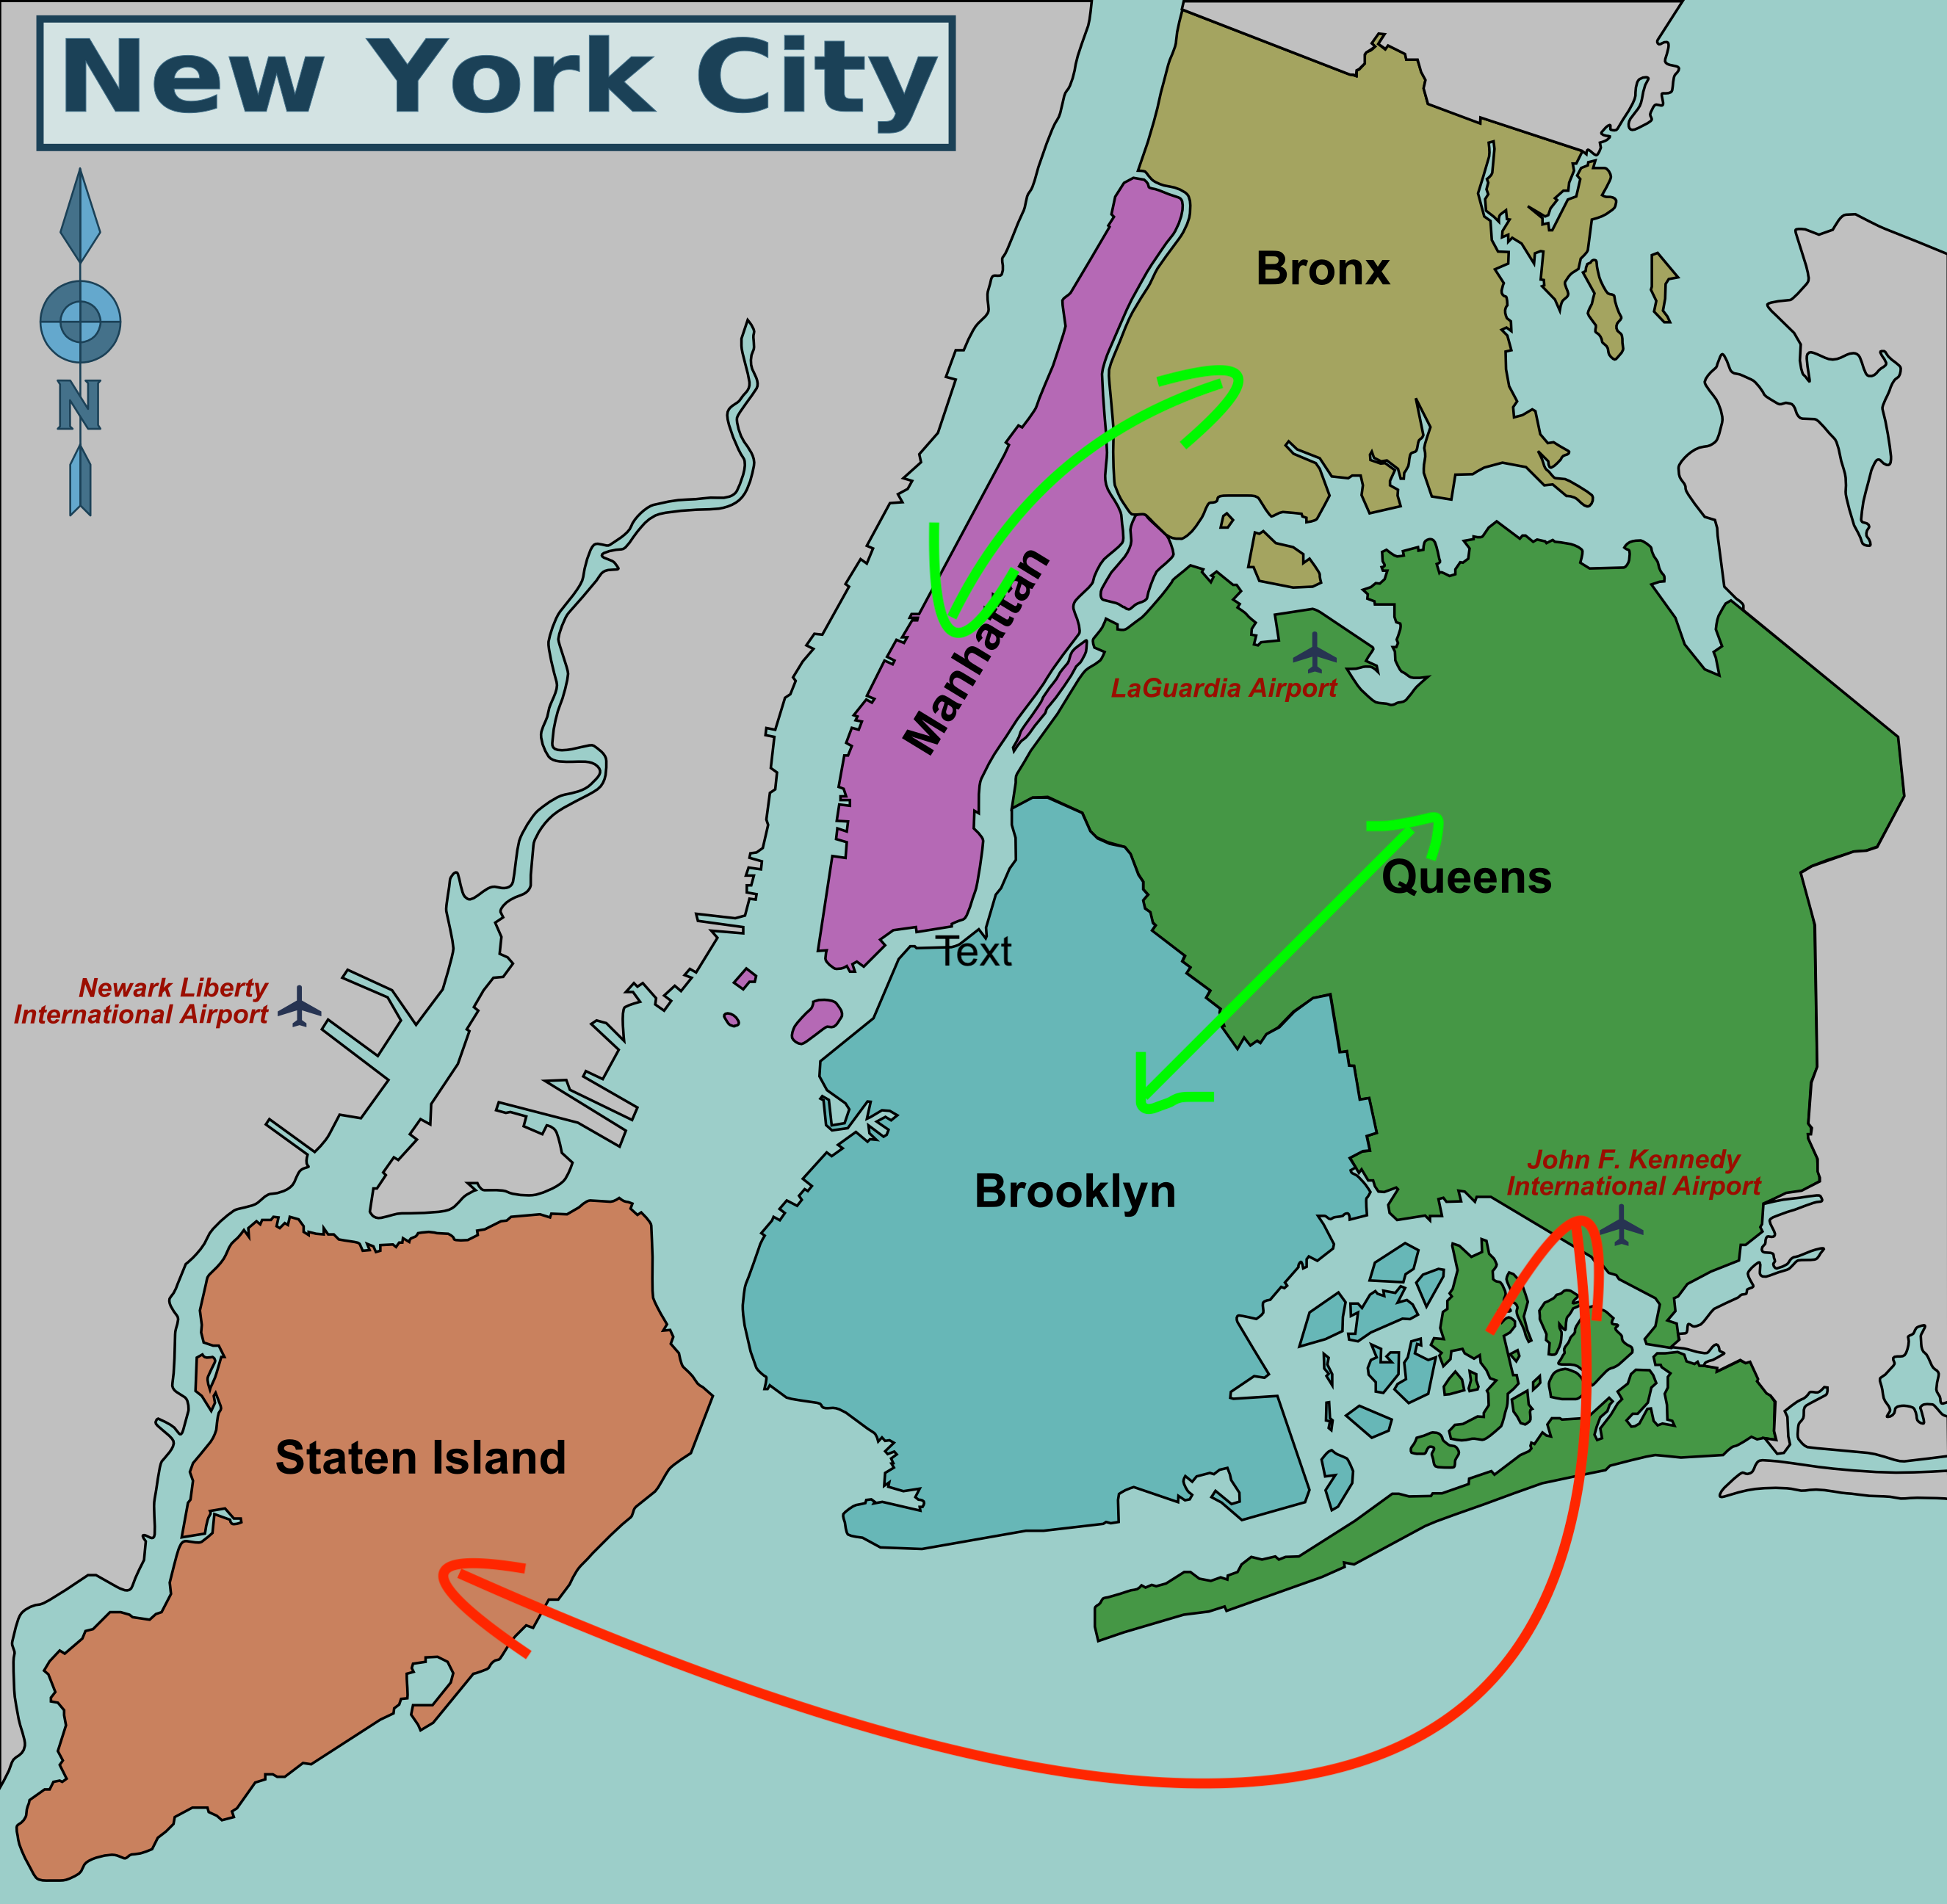

In [15]:
from IPython.display import Image, display

Newest_York = r'Newest_York.png'

display(Image(filename=Newest_York, width=700, height=500))

<h1  style="color: #00FF00; font-weight: bold;">Exercise 5 </h1>
Find the average amount of tolls per hour for trips within the following districts: Manhattan, Bronx, Brooklyn, Queens. Show a graphical representation of the data and report if there is any trend or peak during the day. Overall which district has the largest amount of tolls?

<h5>In my solution I assumed that we had to consider only the trips where the borough_pickup and borough_dropoff where the same. With this assumption in mind i just filtered the starting dataframe with the boroughs of our interest and then grouped by the borough and hour (that I added), aggregating with mean operation the tolls</h5>

In [16]:
df_borough_ex5 = df_borough_ex4.drop("tolls_amount") #alaways to avoid field ambiguity 

df_exercise_5 = df_borough_ex5.join(df_fare_hour,
                                         
                                  (df_borough['medallion'] == df_fare_hour['medallion_fare']) &
                                  (df_borough['pickup_datetime'] == df_fare_hour['pickup_datetime_fare']),
                                
                                  how='inner'
                            
                                  )

columns_of_interest_for_exercise_5 = ['borough_pickup', 'borough_dropoff', 'hour', 'tolls_amount']

df_exercise_5 = df_exercise_5.select(columns_of_interest_for_exercise_5).filter(df_exercise_5['borough_pickup']==df_exercise_5['borough_dropoff'])

df_exercise_5.show(5)
df_exercise_5.count()

+--------------+---------------+-----+------------+
|borough_pickup|borough_dropoff| hour|tolls_amount|
+--------------+---------------+-----+------------+
|     Manhattan|      Manhattan|01:00|         0.0|
|     Manhattan|      Manhattan|01:00|         0.0|
|     Manhattan|      Manhattan|06:00|         0.0|
|     Manhattan|      Manhattan|10:00|         0.0|
|     Manhattan|      Manhattan|16:00|         0.0|
+--------------+---------------+-----+------------+
only showing top 5 rows



340237

In [17]:
df_exercise_5_final = df_exercise_5.groupBy("borough_pickup", "hour").agg(avg("tolls_amount").alias("avg_tolls_district_hour")) #borough dropoff

df_exercise_5_final = df_exercise_5_final.withColumn("hour_int", F.substring("hour", 1, 2).cast("integer"))

df_exercise_5_final = df_exercise_5_final.drop("borough_dropoff", "hour")
df_exercise_5_final.show(20)

+--------------+-----------------------+--------+
|borough_pickup|avg_tolls_district_hour|hour_int|
+--------------+-----------------------+--------+
|        Queens|    0.21036585365853658|      17|
|         Bronx|                    0.0|       1|
|      Brooklyn|   0.028402366863905324|      15|
|         Bronx|     0.3692307692307692|      21|
|      Brooklyn|                    0.0|       0|
|        Queens|    0.07164179104477612|      23|
|         Bronx|                    0.0|       2|
|        Queens|    0.08010471204188482|       6|
|     Manhattan|   0.006115517819238073|      18|
|     Manhattan|   0.007416208104052026|       8|
|     Manhattan|   0.002815919789692...|      13|
|      Brooklyn|                    0.0|      16|
|        Queens|    0.15837563451776648|      14|
|        Queens|     0.1281899109792285|      13|
|        Queens|   0.010015174506828527|       1|
|     Manhattan|   0.004739558892538714|       5|
|      Brooklyn|                    0.0|      10|


In [18]:
import pandas as pd
from bokeh.plotting import figure, show
from bokeh.models import HoverTool

districts = ["Manhattan", "Bronx", "Queens", "Brooklyn"]

pandas_df = df_exercise_5_final.toPandas()

p = figure(title="Average Tolls by Borough and Hour", x_axis_label="Hour", y_axis_label="Average Toll", width=1200)

p.xaxis.major_label_orientation = 1  # Rotate x-axis labels

colors = ["blue", "orange", "green", "red", "purple"]


for i, district in enumerate(districts):
    df_in_question = pandas_df.loc[pandas_df["borough_pickup"] == district]
    df_in_question = df_in_question.sort_values("hour_int", ascending=True)

    line = p.line(df_in_question["hour_int"], df_in_question["avg_tolls_district_hour"],
                  line_color=colors[i], line_width=2, legend_label=district)

    p.circle(df_in_question["hour_int"], df_in_question["avg_tolls_district_hour"],
             fill_color=colors[i], line_color=colors[i], size=6)


    hover = HoverTool(renderers=[line],
                      tooltips=[("Borough", district),
                                ("Hour", "@x" +":00"),
                                ("Average toll $", "@y")])

    p.add_tools(hover)

show(p)


<h5>Bronx seems to be the borough with the highest tools and there seem to be several peaks during the day.</h5>

<h1  style="color: #00FF00; font-weight: bold;">Exercise 6</h1>
Create a dataframe that for each district shows the shortest and longest `trip_distance` starting and ending in the same district. What is the length of the longest and shortest trips in Manhattan?

<h5>To solve this exercise I just needed the dataframe with boroughs computed in exercise 2. First of all i filtered out only the rows where the pickup/dropoff boroughs were equal. Then i simply grouped by borough and aggregating by max the trip_distance and got the final result.</h5>

In [19]:
columnsWeCareAboutForExercise6 = ['borough_pickup', 'borough_dropoff', 'trip_distance']

df_exercise_6 = df_borough.select(columnsWeCareAboutForExercise6).filter(df_borough['borough_pickup']==df_borough['borough_dropoff'])

df_exercise_6.show(2)

+--------------+---------------+-------------+
|borough_pickup|borough_dropoff|trip_distance|
+--------------+---------------+-------------+
|     Manhattan|      Manhattan|         1.35|
|     Manhattan|      Manhattan|        10.99|
+--------------+---------------+-------------+
only showing top 2 rows



In [20]:
df_ex6_final = df_exercise_6\
    .groupBy("borough_pickup") \
    .agg(F.max('trip_distance').alias('max_trip_distance'), F.min('trip_distance').alias('min_trip_distance')) \
    .withColumnRenamed("borough_pickup", "borough") \
    .orderBy("borough")

df_ex6_final.show(truncate=False)

+-------------+-----------------+-----------------+
|borough      |max_trip_distance|min_trip_distance|
+-------------+-----------------+-----------------+
|Bronx        |20.0             |0.0              |
|Brooklyn     |80.5             |0.0              |
|Manhattan    |100.0            |0.0              |
|Queens       |98.7             |0.0              |
|Staten Island|5.7              |0.0              |
+-------------+-----------------+-----------------+



<h5>The longest intra trip in our dataset was from Manhattan to Manhattan and 100 km long (or 100 miles probably since it is in America). </h5>

<h1  style="color: #00FF00; font-weight: bold;">Exercise 7</h1>
Consider only the trips _within_ districts. What are the first and second-most expensive
trips - based on `total_amount` - in every district?

<h5>As usual I first obtinaed the necessary data by applying filtering operations. Then I used the Window of pyspark.sql. I think this was very useful as I could get the desired partition by borough and compute the first and second highest trip costs for that partition.</h5>

In [21]:
columnsWeCareAboutForExercise7 = ['borough_pickup', 'borough_dropoff', 'total_amount']
df_exercise_7 = df_borough.select(columnsWeCareAboutForExercise7).filter(df_borough['borough_pickup']==df_borough['borough_dropoff'])


df_exercise_7.show(2)

+--------------+---------------+------------+
|borough_pickup|borough_dropoff|total_amount|
+--------------+---------------+------------+
|     Manhattan|      Manhattan|        11.3|
|     Manhattan|      Manhattan|       46.75|
+--------------+---------------+------------+
only showing top 2 rows



In [22]:
from pyspark.sql.window import Window

windowSpec = Window.partitionBy("borough_pickup").orderBy(F.desc("total_amount"))

df_exercise_7_final = df_exercise_7.withColumn("first_highest", F.first("total_amount").over(windowSpec))

df_exercise_7_final = df_exercise_7_final.withColumn("second_highest", F.expr("lead(total_amount, 1)").over(windowSpec))


df_exercise_7_true_final = df_exercise_7_final.dropDuplicates(["borough_pickup"])


df_exercise_7_true_final = df_exercise_7_true_final.select("borough_pickup", "first_highest", "second_highest")


df_exercise_7_true_final.show()

+--------------+-------------+--------------+
|borough_pickup|first_highest|second_highest|
+--------------+-------------+--------------+
|         Bronx|         84.0|          80.0|
|      Brooklyn|       180.25|        130.25|
|     Manhattan|        500.0|         475.0|
|        Queens|        138.0|         116.0|
| Staten Island|        91.25|          89.6|
+--------------+-------------+--------------+



<h5>the 500 USD trip in Manhattan is probably the 100 km long one of the previous exercise.

<h1  style="color: #00FF00; font-weight: bold;">Exercise 8</h1>
Create a dataframe where each row represents a driver, and there is one column per district.
For each driver-district, the dataframe provides the maximum number of consecutive trips
for the given driver, within the given district. 

For example, if for driver A we have (sorted by time):
- Trip 1: Bronx → Bronx
- Trip 2: Bronx → Bronx
- Trip 3: Bronx → Manhattan
- Trip 4: Manhattan → Bronx.
    
The maximum number of consecutive trips for Bronx is 2.

<h5> First of all i filtered out only the columns we are interested in for solving this task, therefore I've chosen medallion, pickup_datetime, borough_pickup, borough_dropoff. These lines are enough to get the wanted information but we need to enrich the data. More specifically I assigned the "#number" represnting the ordering according to pickupdatetime by medallion specified with a window function. This will later be useful to understand the order in which trips occured for each taxi driver.</h5>

In [23]:
window_final = Window.partitionBy("medallion").orderBy(F.col("pickup_datetime"))

df_exercise8_almost_final =  df_borough \
    .select("medallion", "borough_pickup", "borough_dropoff", "pickup_datetime") \
    .withColumn("#number", F.rank().over(window_final)) 

df_exercise8_almost_final.show(20)

+--------------------+--------------+---------------+-------------------+-------+
|           medallion|borough_pickup|borough_dropoff|    pickup_datetime|#number|
+--------------------+--------------+---------------+-------------------+-------+
|0038EF45118925A51...|     Manhattan|      Manhattan|2013-01-01 00:07:00|      1|
|0038EF45118925A51...|     Manhattan|      Manhattan|2013-01-01 00:17:00|      2|
|0038EF45118925A51...|     Manhattan|      Manhattan|2013-01-01 00:29:00|      3|
|0038EF45118925A51...|     Manhattan|      Manhattan|2013-01-01 00:48:00|      4|
|0038EF45118925A51...|     Manhattan|      Manhattan|2013-01-01 00:56:00|      5|
|0038EF45118925A51...|     Manhattan|      Manhattan|2013-01-01 01:09:00|      6|
|0038EF45118925A51...|     Manhattan|      Manhattan|2013-01-01 01:27:00|      7|
|0038EF45118925A51...|     Manhattan|      Manhattan|2013-01-01 01:41:00|      8|
|0038EF45118925A51...|     Manhattan|      Manhattan|2013-01-01 01:49:00|      9|
|0038EF45118925A

<h5>Now, in the kernel below, i filtered out only the rows where the borough pickup is equal to the borough dropoff because only these rows will contribute to the final counters. Then i joined the boroughs columns of this filtered table creating an unique attribute in the form of "borough_borough". Now if I display it and scroll down I can see that there are "jumps" in the column #number and these jumps are the columns we have filtered out. Therefore we now have a way to understand/spot when the chain is "broken" for every medallion/borough combination that will end up in the final table.  </h5>

In [24]:
df_exercise8_we_are_very_close = df_exercise8_almost_final\
    .where((F.col("borough_pickup") == F.col("borough_dropoff"))) \
    .select( F.col("medallion"),F.concat(F.col("borough_pickup"), F.lit("_"), F.col("borough_dropoff")).alias("borough"), F.col("#number")) 


df_exercise8_we_are_very_close.show(200)

+--------------------+-------------------+-------+
|           medallion|            borough|#number|
+--------------------+-------------------+-------+
|0038EF45118925A51...|Manhattan_Manhattan|      1|
|0038EF45118925A51...|Manhattan_Manhattan|      2|
|0038EF45118925A51...|Manhattan_Manhattan|      3|
|0038EF45118925A51...|Manhattan_Manhattan|      4|
|0038EF45118925A51...|Manhattan_Manhattan|      5|
|0038EF45118925A51...|Manhattan_Manhattan|      6|
|0038EF45118925A51...|Manhattan_Manhattan|      7|
|0038EF45118925A51...|Manhattan_Manhattan|      8|
|0038EF45118925A51...|Manhattan_Manhattan|      9|
|0038EF45118925A51...|Manhattan_Manhattan|     10|
|0038EF45118925A51...|Manhattan_Manhattan|     11|
|0038EF45118925A51...|Manhattan_Manhattan|     12|
|0038EF45118925A51...|Manhattan_Manhattan|     13|
|0038EF45118925A51...|Manhattan_Manhattan|     14|
|0038EF45118925A51...|Manhattan_Manhattan|     15|
|0038EF45118925A51...|Manhattan_Manhattan|     16|
|0038EF45118925A51...|Manhattan

<h5>Now i simply defined an udf function that spots the longest subsequence of medallion/borough in the previous table. This udf takes a list of numbers coming from #number column and returns the highest value. Then i pivotted the dataframe by borough and got the final result.</h5>

In [25]:
@F.udf(returnType=T.IntegerType())
def max_consecutive_rank(ranks):
    if len(ranks) <= 1:
        return len(ranks)

    consecutive_lengths = []
    current_length = 1

    for i in range(len(ranks) - 1):
        if ranks[i] + 1 == ranks[i+1]:
            current_length += 1
        else:
            consecutive_lengths.append(current_length)
            current_length = 1

    consecutive_lengths.append(current_length)
    longest_len = max(consecutive_lengths)


    
    return longest_len


df_ex8_final_for_real = df_exercise8_we_are_very_close\
    .groupBy("medallion", "borough").agg(max_consecutive_rank(F.collect_list("#number")).alias('maxTrips')) \
    .groupBy("medallion").pivot("borough").max("maxTrips") \
    .fillna(value=0)



df_ex8_final_for_real.show(truncate=False)


+--------------------------------+-----------+-----------------+-------------------+-------------+---------------------------+
|medallion                       |Bronx_Bronx|Brooklyn_Brooklyn|Manhattan_Manhattan|Queens_Queens|Staten Island_Staten Island|
+--------------------------------+-----------+-----------------+-------------------+-------------+---------------------------+
|F49F752E7E9CAAE41B953FB96E25D059|1          |0                |8                  |2            |0                          |
|35E11D9D2AE5C8A80261CF6A309BD9FD|0          |1                |15                 |5            |0                          |
|618BB39CEEAE5E9A6D886E20E005DCA2|0          |1                |12                 |1            |0                          |
|ADFCF211DDD6D788567104FF7B605626|0          |0                |12                 |2            |0                          |
|1109955CCAABCBCE1A22BCED5F1DBFF5|0          |0                |3                  |0            |0            

<h5>Below you can find a test of the results. I purposely selected a medallion that appears in the table above and that is short enough so that you can count manually the consecutive trips and double check the results. I did it for multiple medallions and the code seems to work as intended, you can try it out copying and pasting different medallions in the filtering condition and count manually.</h5>

In [26]:
selected_columns = ['medallion', 'pickup_datetime', 'borough_pickup', 'borough_dropoff']

df_test = df_borough.filter(df_borough.medallion == "D563F5CC514A8754150214749DC69373").orderBy(df_borough.pickup_datetime.asc()).select(selected_columns)

df_test.show(1000)


+--------------------+-------------------+--------------+---------------+
|           medallion|    pickup_datetime|borough_pickup|borough_dropoff|
+--------------------+-------------------+--------------+---------------+
|D563F5CC514A87541...|2013-01-01 00:03:00|     Manhattan|          Bronx|
|D563F5CC514A87541...|2013-01-01 00:26:00|         Bronx|          Bronx|
|D563F5CC514A87541...|2013-01-01 00:52:00|     Manhattan|      Manhattan|
|D563F5CC514A87541...|2013-01-01 01:07:00|     Manhattan|      Manhattan|
|D563F5CC514A87541...|2013-01-01 01:34:00|     Manhattan|      Manhattan|
|D563F5CC514A87541...|2013-01-01 01:52:00|     Manhattan|      Manhattan|
|D563F5CC514A87541...|2013-01-01 02:12:00|     Manhattan|      Manhattan|
|D563F5CC514A87541...|2013-01-01 02:18:00|     Manhattan|      Manhattan|
|D563F5CC514A87541...|2013-01-01 02:24:00|     Manhattan|      Manhattan|
|D563F5CC514A87541...|2013-01-01 02:44:00|     Manhattan|      Manhattan|
|D563F5CC514A87541...|2013-01-01 02:51